In [ ]:
# Neural Network code

### Data cleaning and preprocessing

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from nba_api.stats.endpoints import playercareerstats
import numpy as np
import pandas as pd
from nba_api.stats.endpoints import shotchartdetail
import tensorflow as tf
import tensorflow.keras as keras

pd.set_option('display.max_columns', None)  

seasons = [
    '2016-17', '2017-18', '2018-19',
    '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'
]

def find_player(player_id):
    for season in seasons:
        shots = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=player_id,  
            season_type_all_star='Regular Season',
            context_measure_simple='FGA',
            season_nullable=season
        ).get_data_frames()[0]
        shots['SEASON'] = season
        if 'shots_df' not in locals():
            shots_df = shots
        else:
            shots_df = pd.concat([shots_df, shots], ignore_index=True)
    return shots_df

curry = find_player(201939)
df = curry[['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'LOC_X','LOC_Y', 'SHOT_MADE_FLAG', 'HTM', 'VTM']].copy()
df['Time_remaining'] = df['MINUTES_REMAINING'] * 60 + df['SECONDS_REMAINING']
df['Opponent'] = np.where(df['HTM']  == 'GSW', df['VTM'], df['HTM'])
df['Home'] = np.where(df['HTM'] == 'GSW', 1, 0)
df = df.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM'])
df




,PERIOD,ACTION_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG,Time_remaining,Opponent,Home
0,1,Jump Shot,130,257,0,542,SAS,1
1,1,Step Back Jump shot,189,174,1,486,SAS,1
2,1,Jump Shot,159,229,0,143,SAS,1
3,1,Jump Shot,163,141,0,121,SAS,1
4,2,Jump Shot,-9,267,1,407,SAS,1
...,...,...,...,...,...,...,...,...
8890,4,Step Back Jump shot,129,243,1,19,OKC,0
8891,4,Pullup Jump shot,-4,290,0,0,OKC,0
8892,5,Jump Shot,1,294,1,237,OKC,0
8893,5,Driving Floating Jump Shot,70,142,1,147,OKC,0


Epoch 1/20


c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5125 - loss: 6.4354 - val_accuracy: 0.4986 - val_loss: 0.7383
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078 - loss: 0.9500 - val_accuracy: 0.5084 - val_loss: 0.6908
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5265 - loss: 0.7746 - val_accuracy: 0.5147 - val_loss: 0.6878
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.7161 - val_accuracy: 0.5562 - val_loss: 0.6857
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5438 - loss: 0.7009 - val_accuracy: 0.5576 - val_loss: 0.6867
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 0.7036 - val_accuracy: 0.5646 - val_loss: 0.6860
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5418 - loss: 0.6943 - val_accuracy: 0.5674 - val_loss: 0.6849
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5417 - loss: 0.6945 - val_accuracy: 0.5660 - val_

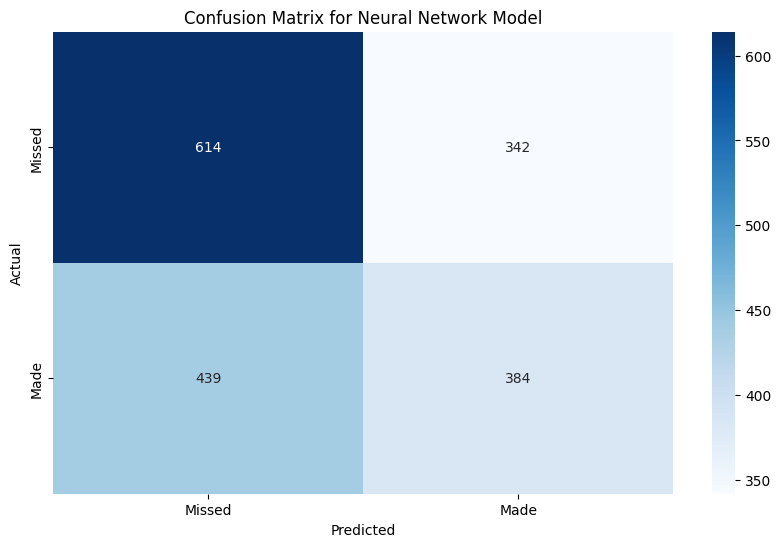

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X = pd.get_dummies(df.drop(columns=['SHOT_MADE_FLAG']), columns=['ACTION_TYPE', 'Opponent'])
X = X.astype('float32')  
y = df['SHOT_MADE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

predictions = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forests

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       956
           1       0.54      0.48      0.51       823

    accuracy                           0.57      1779
   macro avg       0.57      0.57      0.57      1779
weighted avg       0.57      0.57      0.57      1779



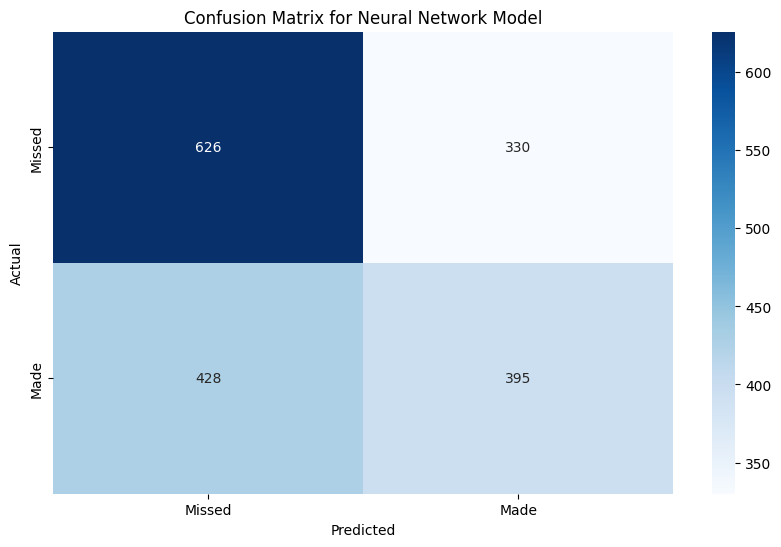

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XGboost

c:\Users\Owner\OneDrive\Documents\GitHub\NBA-Actions\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       956
           1       0.53      0.47      0.49       823

    accuracy                           0.56      1779
   macro avg       0.55      0.55      0.55      1779
weighted avg       0.56      0.56      0.56      1779



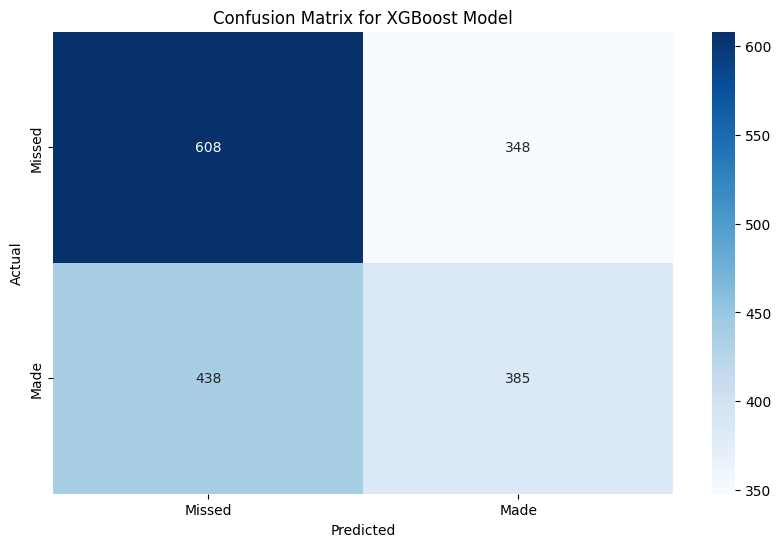

In [40]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       956
           1       0.57      0.42      0.49       823

    accuracy                           0.59      1779
   macro avg       0.58      0.57      0.57      1779
weighted avg       0.58      0.59      0.58      1779



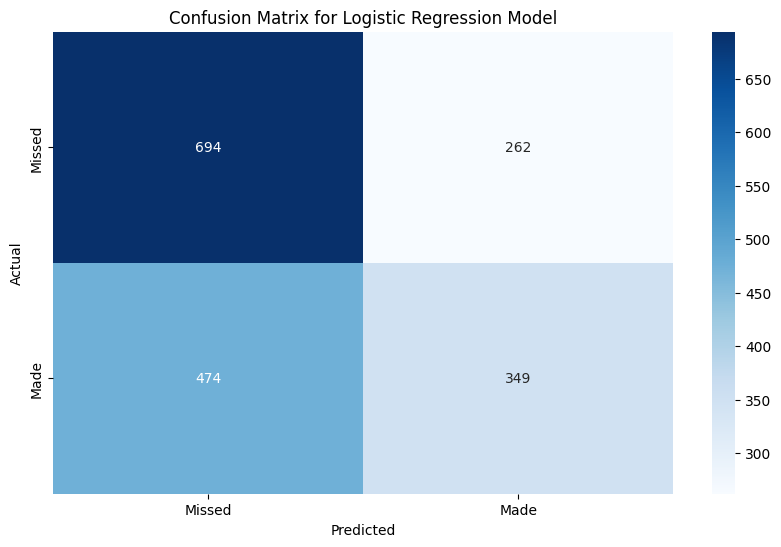

In [42]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter=5000)
lg.fit(X_train, y_train)
lg_predictions = lg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lg_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, lg_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()